In [105]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [98]:
import torch
import torch_geometric
import torch
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from wpca import WPCA, EMPCA
import pandas as pd
from scipy.optimize import curve_fit
import plotly.express as px
import math
import glob

from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as scs
import matplotlib.pyplot as plt
import mplhep as hep
import plotly.graph_objects as go

import matplotlib
import itertools
import copy

import sys
plt.style.use(hep.style.CMS)


In [3]:
# Transform from (eta,phi) to (x,y,z)
def cart_from_etaphi(_eta, _phi):
    theta = 2*math.atan(math.exp(-_eta))
    x = math.sin(theta)*math.cos(_phi)
    y = math.sin(theta)*math.sin(_phi)
    z = math.cos(theta)
    
    return x,y,z

def checkGaps(_vec, _centre):
#     print(_centre)
    _vec = np.unique(_vec)
    maxExcursion = 8
    minExcursion = 8
    if _centre - minExcursion < 1: 
        minSlice = 1
        minValue = 1
    else:
        minSlice = _centre - minExcursion
        minValue = _centre - minExcursion
    maxSlice = _centre + maxExcursion
    if maxSlice > _vec[len(_vec)-1]:
        maxValue = _vec[len(_vec)-1]
    else:
        maxValue = _centre + maxExcursion 
    ref = np.linspace(minValue,maxValue,maxValue-minValue+1)
    _vec = _vec[minSlice-1:maxSlice]
#     print(ref)
#     print(_vec)
    if len(ref) == len(_vec) and (ref == _vec).all():
        return False
    else:
        return True
    
# Define bin boundaries with same numbers of events
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [83]:
def cleaning(_feats, pca_algo):    
    
    X = _feats
    X = np.concatenate((X,X[:,4][:, np.newaxis]), axis=1) #After this step the structure of X is the following [x,y,z,L,energy,energy]
    X = np.concatenate((X,X[:,4][:, np.newaxis]), axis=1) #After this step the structure of X is the following [x,y,z,L,energy,energy,energy]
    
    ####------------------------------------------------ fill array with max E LC per layer ------------------------------------------------####
    maxvalarr = []
    for i in range(int(np.max(X[:,3]))+1):
        if (len(X[:,3][X[:,3] == i]) ==0):
            continue
        layi = X[:,4][X[:,3] == i].copy()
        maxidx = np.argmax(layi)
        xmax = X[:,0][X[:,3] == i][maxidx]
        ymax = X[:,1][X[:,3] == i][maxidx]
        zmax = X[:,2][X[:,3] == i][maxidx]
        lmax = X[:,3][X[:,3] == i][maxidx]
        emax = X[:,4][X[:,3] == i][maxidx]
        maxvalarr.append([xmax,ymax,lmax,emax,zmax])

    maxvalarr = np.array(maxvalarr)

    #### get maxE LC index
    #Consider only layers<28 to find the maxE LC layer
    tmp = np.array([i for i in X if i[3]<28])
    maxidx = np.argmax(tmp[:,4])
    maxl = tmp[maxidx,3]
    maxe = tmp[maxidx,4]
    maxx = tmp[maxidx,0]
    maxy = tmp[maxidx,1]
    maxz = tmp[maxidx,2]

    ####------------------------------------------------ fill array with max E LC per layer for +-N layers from the maxE LC layer ------------------------------------------------####
    cleanarr = []
    for i in range(0,16,1):
        if len(X[:,4][X[:,3] == maxl + i])==0 :
            continue

        maxeidx = np.argmax(X[:,4][X[:,3] == maxl + i])
        xclean = X[:,0][X[:,3] == maxl + i][maxeidx]
        yclean = X[:,1][X[:,3] == maxl + i][maxeidx]
        zclean = X[:,2][X[:,3] == maxl + i][maxeidx]
        lclean = X[:,3][X[:,3] == maxl + i][maxeidx]
        eclean = X[:,4][X[:,3] == maxl + i][maxeidx]
        cleanarr.append([xclean,yclean,zclean,lclean,eclean,eclean,eclean]) #eclean is added three times to prepare the array for the weighted PCA

    for i in range(-1,-11,-1):
        if len(X[:,4][X[:,3] == maxl + i])==0 :
            continue

        maxeidx = np.argmax(X[:,4][X[:,3] == maxl + i])
        xclean = X[:,0][X[:,3] == maxl + i][maxeidx]
        yclean = X[:,1][X[:,3] == maxl + i][maxeidx]
        zclean = X[:,2][X[:,3] == maxl + i][maxeidx]
        lclean = X[:,3][X[:,3] == maxl + i][maxeidx]
        eclean = X[:,4][X[:,3] == maxl + i][maxeidx]
        cleanarr.append([xclean,yclean,zclean,lclean,eclean,eclean,eclean])

    cleanarr = np.array(cleanarr)

    ####------------------------------------------------ PCA with +-N layers from the maxE LC layer ------------------------------------------------####
    cleanarr_pca = np.array([i for i in cleanarr if i[3]<28]) # To compute the PCA axis consider only LC in the EM compartment


    #Energy-weighted PCA
    if pca_algo == 'std':
        pca = PCA(n_components=3)
        pca.fit(cleanarr_pca[:,:3])
    elif pca_algo == 'stdAllLCs':
        pca = PCA(n_components=3)
        pca.fit(X[:,:3])
    elif pca_algo == 'eWeighted':
        pca = WPCA(n_components=3)
        pca.fit(cleanarr_pca[:,:3], weights = cleanarr_pca[:,4:])
    elif pca_algo == 'eWeightedAllLCs':
        pca = WPCA(n_components=3)
        pca.fit(X[:,:3], weights = X[:,4:])

    mincompidx = np.argmax(pca.explained_variance_)

    pca_axis = np.array([*pca.components_[0]])

    origin = [maxx,maxy,maxl,maxz]

    ####------------------------------------------------ fill array with LC with least dist to PCA ------------------------------------------------####
    pcaminarr = []
    distance = []
    index = []
    for i in range(int(np.max(X[:,3]))+1): #Loop on layers
        if (len(X[:,3][X[:,3] == i]) ==0):
            continue
        XL = X[X[:,3] == i].copy()
        dpar = []
        for j in range(XL.shape[0]): #Loop over lcs in layer
            dist = np.linalg.norm(np.cross(pca.components_[mincompidx],XL[j,:3] - np.array([maxx,maxy,maxz])))
            dpar.append(dist)
        dparmin = np.argmin(dpar)
        index.append(i)
        distance.append(dpar[dparmin])

        xpcamin = X[:,0][X[:,3] == i][dparmin]
        ypcamin = X[:,1][X[:,3] == i][dparmin]
        zpcamin = X[:,2][X[:,3] == i][dparmin]
        lpcamin = X[:,3][X[:,3] == i][dparmin]
        epcamin = X[:,4][X[:,3] == i][dparmin]
        pcaminarr.append([xpcamin,ypcamin,lpcamin,epcamin,zpcamin])

    pcaminarr = np.array(pcaminarr)


    ####----------------------------- fill array with LC with least dist to PCA with +-N layers from the maxE LC lay--------------------------------####
    pcaminarr = np.array(pcaminarr)
    pcaminarr = pd.DataFrame(pcaminarr, columns=['x','y','layer','energy','z'])
    cleanpcaarr = np.array(pcaminarr[(pcaminarr['layer']<maxl+15) & (pcaminarr['layer']>maxl-12)])

    return cleanpcaarr, pca_axis, origin

In [81]:
class event:
    def __init__(self, torchEvent, num):
        
        self.number = num
        
        self.eventNumber   = int(torchEvent.event[0])
        self.sampleNumber  = int(torchEvent.event[1])
        self.etaSign       = int(torchEvent.event[2])
        
        # --------- gun information ---------
        self.gunEta     = float(torchEvent.gun[0])
        self.gunPhi     = float(torchEvent.gun[1])
        self.gunEn      = float(torchEvent.gun[2])
        self.gunPID     = int(torchEvent.gun[3])
        self.gunPt      = float(self.gunEn/math.cosh(self.gunEta))
        
        # --------- LCs information ---------        
        self.LCx    = []
        self.LCy    = []
        self.LCl    = []
        self.LCz    = []
        self.LCen   = []
        self.LCt    = []
        self.LCdt   = []
        idxs        = torchEvent.cls.numpy()
        out         = []
        
        for p in range(len(idxs)):
            if p == 0:
                out.append(idxs[p])
            else:
                out.append( out[len(out)-1] + idxs[p] )
        out = np.insert(out,0,0)
        for pos in range( len(out) - 1 ):
            self.LCx.append( np.array(torchEvent.x[:,0][out[pos]:out[pos+1]],  dtype=float) )
            self.LCy.append( np.array(torchEvent.x[:,1][out[pos]:out[pos+1]],  dtype=float) )
            self.LCz.append( np.array(torchEvent.x[:,2][out[pos]:out[pos+1]],  dtype=float) )
            self.LCl.append( np.array(torchEvent.x[:,3][out[pos]:out[pos+1]],  dtype=int) )
            self.LCen.append( np.array(torchEvent.x[:,6][out[pos]:out[pos+1]], dtype=float) )
#             self.LCt.append( np.array(torchEvent.t[:,0][out[pos]:out[pos+1]], dtype=float) )
#             self.LCdt.append( np.array(torchEvent.t[:,1][out[pos]:out[pos+1]], dtype=float) )

#         self.LCx   = np.array(self.LCx,  dtype=object)
#         self.LCy   = np.array(self.LCy,  dtype=object)
        self.LCl   = np.array(self.LCl,  dtype=object)
#         self.LCz   = np.array(self.LCz,  dtype=object)
#         self.LCen  = np.array(self.LCen, dtype=object)
#         self.LCt   = np.array(self.LCt,  dtype=object)
#         self.LCdt  = np.array(self.LCdt, dtype=object)

            
        # --------- nTracksters ---------
        self.nTracksters = len(torchEvent.cls)
        
        # --------- genMatching ---------
        if PileUp:
            self.genMatching = torchEvent.genMatched
            if self.gunEta<0: 
                self.genMatching = torchEvent.genMatched
            else:
                self.genMatching = torchEvent.genMatched - torchEvent.transition_pos_neg
        else:
            # Using this approach, when we use noPU samples the gen-matching condition is always satisfied
            self.genMatching = [i for i in range(len(self.LCx))]
        
        # --------- multi_clus ---------
        self.multi_eta   = []
        self.multi_phi   = []
        self.multi_en    = []
        self.multi_pt    = []
        self.multi_x     = [] 
        self.multi_y     = [] 
        self.multi_z     = []
        self.multi_t     = []
        self.multi_index = []
        for trk in range(len(torchEvent.multi)):
            eta     = torchEvent.multi[trk][0]
            phi     = torchEvent.multi[trk][1]
            en      = torchEvent.multi[trk][2]
            pt      = en/math.cosh(eta)
            x, y, z = cart_from_etaphi(eta, phi)
            
            self.multi_eta.append( float(eta) )
            self.multi_phi.append( float(phi) )
            self.multi_en.append( float(en) )
            self.multi_pt.append( float(pt) )
            self.multi_x.append( float(x) ) 
            self.multi_y.append( float(y) ) 
            self.multi_z.append( float(z) )
#             self.multi_t.append( float(torchEvent.timing[trk]) )
            self.multi_index.append( trk )
    
        self.multi_eta   = np.array(self.multi_eta)
        self.multi_phi   = np.array(self.multi_phi)
        self.multi_en    = np.array(self.multi_en)
        self.multi_pt    = np.array(self.multi_pt)
        self.multi_x     = np.array(self.multi_x) 
        self.multi_y     = np.array(self.multi_y) 
        self.multi_z     = np.array(self.multi_z)
    
        # --------- PCA and energy ratio for quality trackster ---------
#         self.wpca              = []
#         self.wpca_explVar      = []
#         self.wpca_explVarRatio = []
        
#         self.EnRatio_maxE      = []
#         self.EnRatio_sumE      = []
#         maxElc                 = max(self.multi_en)
#         sumElc                 = sum(self.multi_en)
        
        self.skim              = []
#         self.gaps              = []
        
        for trk in range(self.nTracksters):
#             if len(self.LCx[trk]) > 3: #Require at least 3 LCs in the tracksters
#                 pca = WPCA(n_components=3)
#                 pca.fit(np.stack((self.LCx[trk], self.LCy[trk], self.LCz[trk])).T, weights = np.stack((self.LCen[trk], self.LCen[trk], self.LCen[trk])).T)
#                 self.wpca.append(pca.components_[0])
#                 self.wpca_explVar.append(pca.explained_variance_[0])
#                 self.wpca_explVarRatio.append(pca.explained_variance_ratio_[0])
#             else:
#                 self.wpca.append(-1.)
#                 self.wpca_explVar.append(-1.)
#                 self.wpca_explVarRatio.append(-1.)
#             self.EnRatio_maxE.append(self.multi_en[trk]/maxElc)
#             self.EnRatio_sumE.append(self.multi_en[trk]/sumElc)
#             self.gaps.append(checkGaps(self.LCl[trk], self.LCl[trk][np.argmax(self.LCen[trk])]))
            
#             # Skimmer
#             # * explained variance less than 0.95 if en_trk > 50, explained variance less than 0.90 if en_trk < 50 and ratio_sum > 1, otherwise less than 0.95
#             # * at least 3 LCs in the trackster (conditions required above)
#             # * the trackster to be removed should not be the most energetic
#             # * we remove trackster entiriley contained in the HAD compartment 
            
#             if self.multi_en[trk] > 50: 
#                 explVarRatio_cut = 0.95 
#             else:
#                 explVarRatio_cut = 0.92
#             self.skim.append( (self.wpca_explVarRatio[trk] < explVarRatio_cut and self.EnRatio_maxE[trk] != 1) or min(self.LCl[trk]) >= 28)
            
#             print(self.LCl[trk])
            emLCs = self.LCl[trk] < 28
#             print(emLCs)
            self.skim.append( len(emLCs[emLCs==True])<3 )
#             print(len(emLCs[emLCs==True])>3)

                
#         self.wpca              = np.array(self.wpca,              dtype=object)
#         self.wpca_explVar      = np.array(self.wpca_explVar,      dtype=object)
#         self.wpca_explVarRatio = np.array(self.wpca_explVarRatio, dtype=object)
#         self.EnRatio_maxE      = np.array(self.EnRatio_maxE,      dtype=object)
#         self.EnRatio_sumE      = np.array(self.EnRatio_sumE,      dtype=object)
        self.skim              = np.array(self.skim,              dtype=object)
            
        # --------- simHits ---------
        self.simHit_x  = torchEvent.simrechits[0]
        self.simHit_y  = torchEvent.simrechits[1]
        self.simHit_z  = torchEvent.simrechits[2]
        self.simHit_l  = torchEvent.simrechits[3]
        self.simHit_en = torchEvent.simrechits[4]
        
        # --------- recHits ---------
        self.recHit_x  = torchEvent.rechits[0]
        self.recHit_y  = torchEvent.rechits[1]
        self.recHit_z  = torchEvent.rechits[2]
        self.recHit_l  = torchEvent.rechits[3]
        self.recHit_en = torchEvent.rechits[4]

        # --------- cleaning ---------
        self.cleanedLCx = []
        self.cleanedLCy = []
        self.cleanedLCl = []
        self.cleanedLCz = []
        self.cleanedLCen = []
        self.cleanedLCt = []
        self.cleanedLCdt = []
        self.pca = []
        self.pca_signed = []
        self.pca_origin = []
        for i in range(len(self.LCx)):
#             if min(self.LCl[i]) < 28:
            if self.skim[i] == False:
#             if True:
                cleanpcaarr, pca_axis, origin = cleaning(np.array([[self.LCx[i][j], self.LCy[i][j], self.LCz[i][j], self.LCl[i][j], self.LCen[i][j]] for j in range(len(self.LCx[i]))]), 
                                                         'eWeighted')
                self.cleanedLCx.append(cleanpcaarr[:,0])
                self.cleanedLCy.append(cleanpcaarr[:,1])
                self.cleanedLCl.append(cleanpcaarr[:,2])
                self.cleanedLCz.append(cleanpcaarr[:,4])
                self.cleanedLCen.append(cleanpcaarr[:,3])
    #             self.cleanedLCt.append(cleanpcaarr[:,5])
    #             self.cleanedLCdt.append(cleanpcaarr[:,6])
                self.pca.append(pca_axis)
                if pca_axis[2] * self.cleanedLCz[0][0] < 0:
                    pca_axis = [(-1) * i for i in pca_axis]
                self.pca_signed.append(pca_axis)
                self.pca_origin.append(origin)
            
        self.pca = np.array(self.pca)
        self.pca_signed = np.array(self.pca_signed)
                

# Load data

### CLUE3D

In [84]:
raw_dir='/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4/step3_noLinking/step4/' 
PileUp = False

fnamelist = [filepath for filepath in glob.glob(raw_dir+'data*.pt')]

ele_CLUE = []
j = 0
for i in tqdm(fnamelist):
    idx = torch.load(i)
    ele_CLUE.append(event(idx,j))
    j += 1
    
# idx = torch.load('/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4/step3/step4/data_n_38_125.pt')
# ele.append(event(idx))

100%|██████████| 38551/38551 [18:59<00:00, 33.82it/s]


### GLUE3D

In [85]:
raw_dir='/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4/step3_GLUE3D_allSamples/step4/'
PileUp = False

fnamelist = [filepath for filepath in glob.glob(raw_dir+'data*.pt')]

ele_GLUE = []
j = 0
for i in tqdm(fnamelist):
    idx = torch.load(i)
    ele_GLUE.append(event(idx,j))
    j += 1
    
# idx = torch.load('/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4/step3/step4/data_n_27_129.pt')
# ele.append(event(idx))

100%|██████████| 38551/38551 [20:07<00:00, 31.93it/s]


# Event display

In [103]:
def findColor(_colors, _en, _print=False):
    en_sum = sum(_en)
    en_array = np.array([c[0] for c in _colors], dtype=float)
    col = _colors[ np.where( (abs(en_sum - en_array) < 0.0001) )[0][0] ][1]
    if not 'tab' in col and _print:
        col = 'tab:-->'+col
    return col


def eventDisplay(_ele, _ele_bis, cleaned = False, multi = False, removeTrk = False):
    
    print('------- Event information -------') 
    print('event, sample, eta:', _ele.eventNumber, _ele.sampleNumber, _ele.etaSign)

    # --------- gun information ---------
    print('------- Gun information -------') 
    print('eta gun:',  round(_ele.gunEta,3)) 
    print('phi gun:',  round(_ele.gunPhi,3))
    print('En gun:',   round(_ele.gunEn,3))
    print('ID gun:',   _ele.gunPID) 
    print('pT gun:',   round(_ele.gunPt,3))
    
    ############
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive', 'tab:cyan', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors_leftovers = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey', 'olive', 'cyan', 'blue', 'orange', 'green', 'red']
    
    trks_CLUE   = _ele.multi_en
    trks_GLUE   = _ele_bis.multi_en

    colors_CLUE = np.array([[item,colors[counter]] for counter,item in enumerate(trks_CLUE)])
    colors_GLUE = []

    idxsToBeRemoved = []
    for idx_GLUE in range(len(trks_GLUE)):
        for idx_CLUE in range(len(trks_CLUE)):
            if abs(trks_GLUE[idx_GLUE] == trks_CLUE[idx_CLUE]):
                colors_GLUE.append([trks_GLUE[idx_GLUE], colors[idx_CLUE]])
                idxsToBeRemoved.append(idx_GLUE)      
    trks_GLUE = np.delete(trks_GLUE, idxsToBeRemoved)

    idxsToBeRemoved = []
    indeces = [i for i in range(len(trks_CLUE))]
    for i,j in itertools.combinations(indeces, 2):
        for idx_GLUE in range(len(trks_GLUE)):
            if abs(trks_CLUE[i] + trks_CLUE[j] - trks_GLUE[idx_GLUE]) < 0.0001:
                find_max = max(trks_CLUE[i], trks_CLUE[j])
                index_max = np.where(np.array(trks_CLUE) == find_max)
                colors_GLUE.append([trks_GLUE[idx_GLUE], colors[index_max[0][0]]])
                idxsToBeRemoved.append(idx_GLUE)      
    trks_GLUE = np.delete(trks_GLUE, idxsToBeRemoved)

    #For GLUE3D tracksters that are not made by a union of two tracksters in CLUE3D, e.g. addition of tracksters made of a single LC or merging of more than two tracksters
    for count, element in enumerate(trks_GLUE):
        colors_GLUE.append([element, colors_leftovers[count]])
                        
    ############
    
    # --------- tracksters information ---------
    print('------- Tracksters information CLUE -------') 
    print('color    energy     ratio_maxE     ratio_sumE     explVarRatio    discarded')
    for trk in range(len(_ele.multi_en)):
        # color, energy, ratio wrt to most energetic one, explained variance, skimming
        print(findColor(colors_CLUE, _ele.LCen[trk])[4:], '    ',  
              round(_ele.multi_en[trk],3), '    ', 
              str(round((_ele.multi_en[trk] / max(_ele.multi_en)) * 100,2))+'%', '    ', 
              str(round((_ele.multi_en[trk] / sum(_ele.multi_en)) * 100,2))+'%', '        ', 
#               round(_ele.wpca_explVarRatio[trk],3), '        ', 
              _ele.skim[trk])
    if removeTrk:
        print('------- Effects of the skimming -------') 
        print('E_ev/E_GEN', (sum(_ele.multi_en) / _ele.gunEn) - 1 )
        print('E_ev/E_GEN', (sum(_ele.multi_en[_ele.skim==False]) / _ele.gunEn) - 1  )
        
    
    enMultiplier = 30
    
    fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(42,17))
    

    #ax0
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax0.scatter(_ele.LCx[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, color=findColor(colors_CLUE, _ele.LCen[trk]))
    ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax0.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

    #ax1
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax1.scatter(_ele.LCy[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, color=findColor(colors_CLUE, _ele.LCen[trk]))
    ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax1.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

    #ax2
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax2.scatter(_ele.LCx[trk], _ele.LCy[trk], s=_ele.LCen[trk]*enMultiplier, color=findColor(colors_CLUE, _ele.LCen[trk]))
    ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')

    #ax3
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax3.scatter(_ele.LCx[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, color=findColor(colors_CLUE, _ele.LCen[trk]))
    ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    #ax4
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax4.scatter(_ele.LCy[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, color=findColor(colors_CLUE, _ele.LCen[trk]))
    ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    if multi:
        for trk in range(len(_ele.multi_x)):
            ax2.arrow(0, 0, _ele.multi_x[trk] * 800, _ele.multi_y[trk] * 800, color='tab:red')
            ax3.arrow(0, 0, _ele.multi_x[trk] * 800, _ele.multi_z[trk] * 800, color='tab:red')
            ax4.arrow(0, 0, _ele.multi_y[trk] * 800, _ele.multi_z[trk] * 800, color='tab:red')
            
    plt.show()
    
    #############################################################################
    print('------- Tracksters information GLUE -------') 
    print('color    energy     ratio_maxE     ratio_sumE     explVarRatio    discarded')
    for trk in range(len(_ele_bis.multi_en)):
        # color, energy, ratio wrt to most energetic one, explained variance, skimming
        print(findColor(colors_GLUE, _ele_bis.LCen[trk], True)[4:], '    ',  
              round(_ele_bis.multi_en[trk],3), '    ', 
              str(round((_ele_bis.multi_en[trk] / max(_ele_bis.multi_en)) * 100,2))+'%', '    ', 
              str(round((_ele_bis.multi_en[trk] / sum(_ele_bis.multi_en)) * 100,2))+'%', '        ', 
#               round(_ele_bis.wpca_explVarRatio[trk],3), '        ', 
              _ele_bis.skim[trk])
    if removeTrk:
        print('------- Effects of the skimming -------') 
        print('E_ev/E_GEN', (sum(_ele_bis.multi_en) / _ele_bis.gunEn) - 1 )
        print('E_ev/E_GEN', (sum(_ele_bis.multi_en[_ele_bis.skim==False]) / _ele_bis.gunEn) - 1  )

    
    fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(42,17))

    #ax0
    for trk in range(len(_ele_bis.LCx)):
        if not trk in _ele_bis.genMatching: continue
        ax0.scatter(_ele_bis.LCx[trk], _ele_bis.LCl[trk], s=_ele_bis.LCen[trk]*enMultiplier, color=findColor(colors_GLUE, _ele_bis.LCen[trk]))
    ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax0.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

    #ax1
    for trk in range(len(_ele_bis.LCx)):
        if not trk in _ele_bis.genMatching: continue
        ax1.scatter(_ele_bis.LCy[trk], _ele_bis.LCl[trk], s=_ele_bis.LCen[trk]*enMultiplier, color=findColor(colors_GLUE, _ele_bis.LCen[trk]))
    ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax1.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

    #ax2
    for trk in range(len(_ele_bis.LCx)):
        if not trk in _ele_bis.genMatching: continue
        ax2.scatter(_ele_bis.LCx[trk], _ele_bis.LCy[trk], s=_ele_bis.LCen[trk]*enMultiplier, color=findColor(colors_GLUE, _ele_bis.LCen[trk]))
    ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')

    #ax3
    for trk in range(len(_ele_bis.LCx)):
        if not trk in _ele_bis.genMatching: continue
        ax3.scatter(_ele_bis.LCx[trk], _ele_bis.LCz[trk], s=_ele_bis.LCen[trk]*enMultiplier, color=findColor(colors_GLUE, _ele_bis.LCen[trk]))
    ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    #ax4
    for trk in range(len(_ele_bis.LCx)):
        if not trk in _ele_bis.genMatching: continue
        ax4.scatter(_ele_bis.LCy[trk], _ele_bis.LCz[trk], s=_ele_bis.LCen[trk]*enMultiplier, color=findColor(colors_GLUE, _ele_bis.LCen[trk]))
    ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    if multi:
        for trk in range(len(_ele_bis.multi_x)):
            ax2.arrow(0, 0, _ele_bis.multi_x[trk] * 800, _ele_bis.multi_y[trk] * 800, color='tab:red')
            ax3.arrow(0, 0, _ele_bis.multi_x[trk] * 800, _ele_bis.multi_z[trk] * 800, color='tab:red')
            ax4.arrow(0, 0, _ele_bis.multi_y[trk] * 800, _ele_bis.multi_z[trk] * 800, color='tab:red')
            
    plt.show()
    
    ##### -------- To remove pathological trackster -------- #####
    if removeTrk:
                        
        fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(42,17))

        #ax0
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching or _ele.skim[trk]: continue
            ax0.scatter(_ele.LCx[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
        ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax0.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

        #ax1
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching or _ele.skim[trk]: continue
            ax1.scatter(_ele.LCy[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
        ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax1.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

        #ax2
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching or _ele.skim[trk]: continue
            ax2.scatter(_ele.LCx[trk], _ele.LCy[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
        ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')

        #ax3
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching or _ele.skim[trk]: continue
            ax3.scatter(_ele.LCx[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
        ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')

        #ax4
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching or _ele.skim[trk]: continue
            ax4.scatter(_ele.LCy[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
        ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')
        
        plt.show()
        
        
    if cleaned:
        fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(42,17))
        
        colors_cleaned = ['blue', 'orange', 'green', 'red', 'purple', 'sienna', 'pink', 'grey', 'olive', 'cyan']
        color_axis = 'black'
        
        trk_idx = []
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching or _ele.skim[trk]: continue
            trk_idx.append(trk)
            ax0.scatter(_ele.LCx[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            ax1.scatter(_ele.LCy[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            ax2.scatter(_ele.LCx[trk], _ele.LCy[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            ax3.scatter(_ele.LCx[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            ax4.scatter(_ele.LCy[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            
        for trk in range(len(_ele.cleanedLCx)):
            ax0.scatter(_ele.cleanedLCx[trk], _ele.cleanedLCl[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]]) 
            ax1.scatter(_ele.cleanedLCy[trk], _ele.cleanedLCl[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]])
            ax2.scatter(_ele.cleanedLCx[trk], _ele.cleanedLCy[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]])
            ax3.scatter(_ele.cleanedLCx[trk], _ele.cleanedLCz[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]])
            ax4.scatter(_ele.cleanedLCy[trk], _ele.cleanedLCz[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]])


        ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax0.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')
        
        ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax1.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')
        
        ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')
        ax2.set_ylim(ax2.get_ylim())
        ax2.set_xlim(ax2.get_xlim())

        ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')
        ax3.set_ylim(ax3.get_ylim())
        ax3.set_xlim(ax3.get_xlim())

        ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')
        ax4.set_ylim(ax4.get_ylim())
        ax4.set_xlim(ax4.get_xlim())

        for trk in range(len(_ele.pca)):
            x = _ele.pca[trk][0] #x-pca
            y = _ele.pca[trk][1] #y-pca
            z = _ele.pca[trk][2] #z-pca
            centre_x = _ele.pca_origin[trk][0]
            centre_y = _ele.pca_origin[trk][1]
            centre_l = _ele.pca_origin[trk][2]
            centre_z = _ele.pca_origin[trk][3]
            
            ax2.arrow(*[centre_x,centre_y], x * 800, y * 800, color=color_axis) 
            ax2.arrow(*[centre_x,centre_y], x * -800, y * -800, color=color_axis) 
            ax3.arrow(*[centre_x,centre_z], x * 800, z * 800, color=color_axis) 
            ax3.arrow(*[centre_x,centre_z], x * -800, z * -800, color=color_axis) 
            ax4.arrow(*[centre_y,centre_z], y * 800, z * 800, color=color_axis) 
            ax4.arrow(*[centre_y,centre_z], y * -800, z * -800, color=color_axis) 


        plt.show()
        
        ########################################################
        fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(42,17))

        colors_cleaned = ['blue', 'orange', 'green', 'red', 'purple', 'sienna', 'pink', 'grey', 'olive', 'cyan']
        color_axis = 'black'

        trk_idx = []
        for trk in range(len(_ele_bis.LCx)):
            if not trk in _ele_bis.genMatching or _ele_bis.skim[trk]: continue
            trk_idx.append(trk)
            ax0.scatter(_ele_bis.LCx[trk], _ele_bis.LCl[trk], s=_ele_bis.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            ax1.scatter(_ele_bis.LCy[trk], _ele_bis.LCl[trk], s=_ele_bis.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            ax2.scatter(_ele_bis.LCx[trk], _ele_bis.LCy[trk], s=_ele_bis.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            ax3.scatter(_ele_bis.LCx[trk], _ele_bis.LCz[trk], s=_ele_bis.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])
            ax4.scatter(_ele_bis.LCy[trk], _ele_bis.LCz[trk], s=_ele_bis.LCen[trk]*enMultiplier, alpha=0.3, color=colors[trk])

        for trk in range(len(_ele_bis.cleanedLCx)):
            ax0.scatter(_ele_bis.cleanedLCx[trk], _ele_bis.cleanedLCl[trk], s=_ele_bis.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]]) 
            ax1.scatter(_ele_bis.cleanedLCy[trk], _ele_bis.cleanedLCl[trk], s=_ele_bis.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]])
            ax2.scatter(_ele_bis.cleanedLCx[trk], _ele_bis.cleanedLCy[trk], s=_ele_bis.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]])
            ax3.scatter(_ele_bis.cleanedLCx[trk], _ele_bis.cleanedLCz[trk], s=_ele_bis.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]])
            ax4.scatter(_ele_bis.cleanedLCy[trk], _ele_bis.cleanedLCz[trk], s=_ele_bis.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[trk]])


        ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax0.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

        ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax1.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

        ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')
        ax2.set_ylim(ax2.get_ylim())
        ax2.set_xlim(ax2.get_xlim())

        ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')
        ax3.set_ylim(ax3.get_ylim())
        ax3.set_xlim(ax3.get_xlim())

        ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')
        ax4.set_ylim(ax4.get_ylim())
        ax4.set_xlim(ax4.get_xlim())

        for trk in range(len(_ele_bis.pca)):
            x = _ele_bis.pca[trk][0] #x-pca
            y = _ele_bis.pca[trk][1] #y-pca
            z = _ele_bis.pca[trk][2] #z-pca
            centre_x = _ele_bis.pca_origin[trk][0]
            centre_y = _ele_bis.pca_origin[trk][1]
            centre_l = _ele_bis.pca_origin[trk][2]
            centre_z = _ele_bis.pca_origin[trk][3]

            ax2.arrow(*[centre_x,centre_y], x * 800, y * 800, color=color_axis) 
            ax2.arrow(*[centre_x,centre_y], x * -800, y * -800, color=color_axis) 
            ax3.arrow(*[centre_x,centre_z], x * 800, z * 800, color=color_axis) 
            ax3.arrow(*[centre_x,centre_z], x * -800, z * -800, color=color_axis) 
            ax4.arrow(*[centre_y,centre_z], y * 800, z * 800, color=color_axis) 
            ax4.arrow(*[centre_y,centre_z], y * -800, z * -800, color=color_axis) 


        plt.show()


In [87]:
def plot3D(_el):
    data = []
    for trk in range(len(_el.multi_en)):
        data.append( go.Scatter3d( x      = _el.LCx[trk], 
                                   y      = _el.LCy[trk], 
                                   z      = _el.LCz[trk],
                                   mode   = 'markers',
                                   marker = dict( size      = 3,
#                                        symbol='square',
#                                        color='red',                # set color to an array/list of desired values
#                                        colorscale= 'Viridis',   # choose a colorscale
                                                  opacity   = 1.0,
                                                  showscale = False )
                                 )
                   )


    fig = go.Figure(data = data)
    fig.update_layout(autosize = False,
                      width    = 800,
                      height   = 800)
    fig.show()


In [88]:
def eventDisplayHits(_ele):
    
    print('event, sample, eta:', _ele.eventNumber, _ele.sampleNumber, _ele.etaSign)

    fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(40,15), dpi=150)

    ax0.scatter(_ele.simHit_x,_ele.simHit_l,s=_ele.simHit_en*10, c='black')
    ax0.set_xlim(ax0.get_xlim())
    ax0.set_ylim(ax0.get_ylim())
    ax0.scatter(_ele.recHit_x,_ele.recHit_l,s=_ele.recHit_en*10, c='lightgray', alpha=0.9)
    ax0.scatter(_ele.simHit_x,_ele.simHit_l,s=_ele.simHit_en*10, c='black')
    ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax0.set_ylabel('L', fontsize = 25, fontweight = 'bold')

    ax1.scatter(_ele.simHit_y,_ele.simHit_l,s=_ele.simHit_en*10, c='black')
    ax1.set_xlim(ax1.get_xlim())
    ax1.set_ylim(ax1.get_ylim())
    ax1.scatter(_ele.recHit_y,_ele.recHit_l,s=_ele.recHit_en*10, c='lightgray', alpha=0.9)
    ax1.scatter(_ele.simHit_y,_ele.simHit_l,s=_ele.simHit_en*10, c='black')
    ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax1.set_ylabel('L', fontsize = 25, fontweight = 'bold')

    #sel_l is to remove hits over the layer reported in x-L and y-L views 
    sel_l = _ele.simHit_l<ax1.get_ylim()[1]
    ax2.scatter(_ele.simHit_x[sel_l],_ele.simHit_y[sel_l],s=_ele.simHit_en[sel_l]*10, c='black')
    ax2.set_xlim(ax2.get_xlim())
    ax2.set_ylim(ax2.get_ylim())
    sel_l = _ele.recHit_l<ax1.get_ylim()[1]
    ax2.scatter(_ele.recHit_x[sel_l],_ele.recHit_y[sel_l],s=_ele.recHit_en[sel_l]*10, c='lightgray', alpha=0.9)
    sel_l = _ele.simHit_l<ax1.get_ylim()[1]
    ax2.scatter(_ele.simHit_x[sel_l],_ele.simHit_y[sel_l],s=_ele.simHit_en[sel_l]*10, c='black')
    ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')
    ax2.set_title('Hits below layers '+str(int(ax1.get_ylim()[1])), fontsize = 25, fontstyle = 'italic')

    ax3.scatter(_ele.simHit_x,_ele.simHit_z,s=_ele.simHit_en*10, c='black')
    ax3.set_xlim(ax3.get_xlim())
    ax3.set_ylim(ax3.get_ylim())
    ax3.scatter(_ele.recHit_x,_ele.recHit_z,s=_ele.recHit_en*10, c='lightgray', alpha=0.9)
    ax3.scatter(_ele.simHit_x,_ele.simHit_z,s=_ele.simHit_en*10, c='black')
    ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    ax4.scatter(_ele.simHit_y,_ele.simHit_z,s=_ele.simHit_en*10, c='black')
    ax4.set_xlim(ax4.get_xlim())
    ax4.set_ylim(ax4.get_ylim())
    ax4.scatter(_ele.recHit_y,_ele.recHit_z,s=_ele.recHit_en*10, c='lightgray', alpha=0.9)
    ax4.scatter(_ele.simHit_y,_ele.simHit_z,s=_ele.simHit_en*10, c='black')
    ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    for i in range(len(_ele.multi_eta)):

        if not i in _ele.genMatching: continue

#         if neg and _ele.LCz[multi_clus2d[i]].flatten()[0]>0: continue
#         if not neg and _ele.LCz[multi_clus2d[i]].flatten()[0]<0: continue
            
        clusE = _ele.LCen[i].flatten()
        clusX = _ele.LCx[i].flatten()
        clusY = _ele.LCy[i].flatten()
        clusZ = _ele.LCz[i].flatten()
        clusL = _ele.LCl[i].flatten()

        ax0.scatter(clusX,clusL,s=clusE*10,alpha=0.5)
        ax1.scatter(clusY,clusL,s=clusE*10,alpha=0.5)
        ax2.scatter(clusX,clusY,s=clusE*10,alpha=0.5)
        ax3.scatter(clusX,clusZ,s=clusE*10,alpha=0.5)
        ax4.scatter(clusY,clusZ,s=clusE*10,alpha=0.5)

    plt.savefig('event.png', facecolor='white', dpi=300, bbox_inches='tight')
    plt.show()


In [106]:
df_merge[(df_merge.nTrk_x!=df_merge.nTrk_y)].sample()

,event,sample,eta,gunEn,gunEta,gunPt,gunPhi,nTrk_x,nTrk_y
20234,69,23,1,46.448803,1.955603,12.885161,1.310297,2,1


(17981, 28917)
------- Event information -------
event, sample, eta: 35 1 1
------- Gun information -------
eta gun: 2.339
phi gun: -3.122
En gun: 204.456
ID gun: 11
pT gun: 39.081
------- Tracksters information CLUE -------
color    energy     ratio_maxE     ratio_sumE     explVarRatio    discarded
blue      8.656      9.63%      4.77%          False
orange      32.97      36.67%      18.17%          False
green      8.198      9.12%      4.52%          False
red      2.681      2.98%      1.48%          False
purple      37.792      42.03%      20.83%          False
brown      1.236      1.38%      0.68%          False
pink      89.906      100.0%      49.55%          False
------- Effects of the skimming -------
E_ev/E_GEN -0.11257970173785059
E_ev/E_GEN -0.11257970173785059


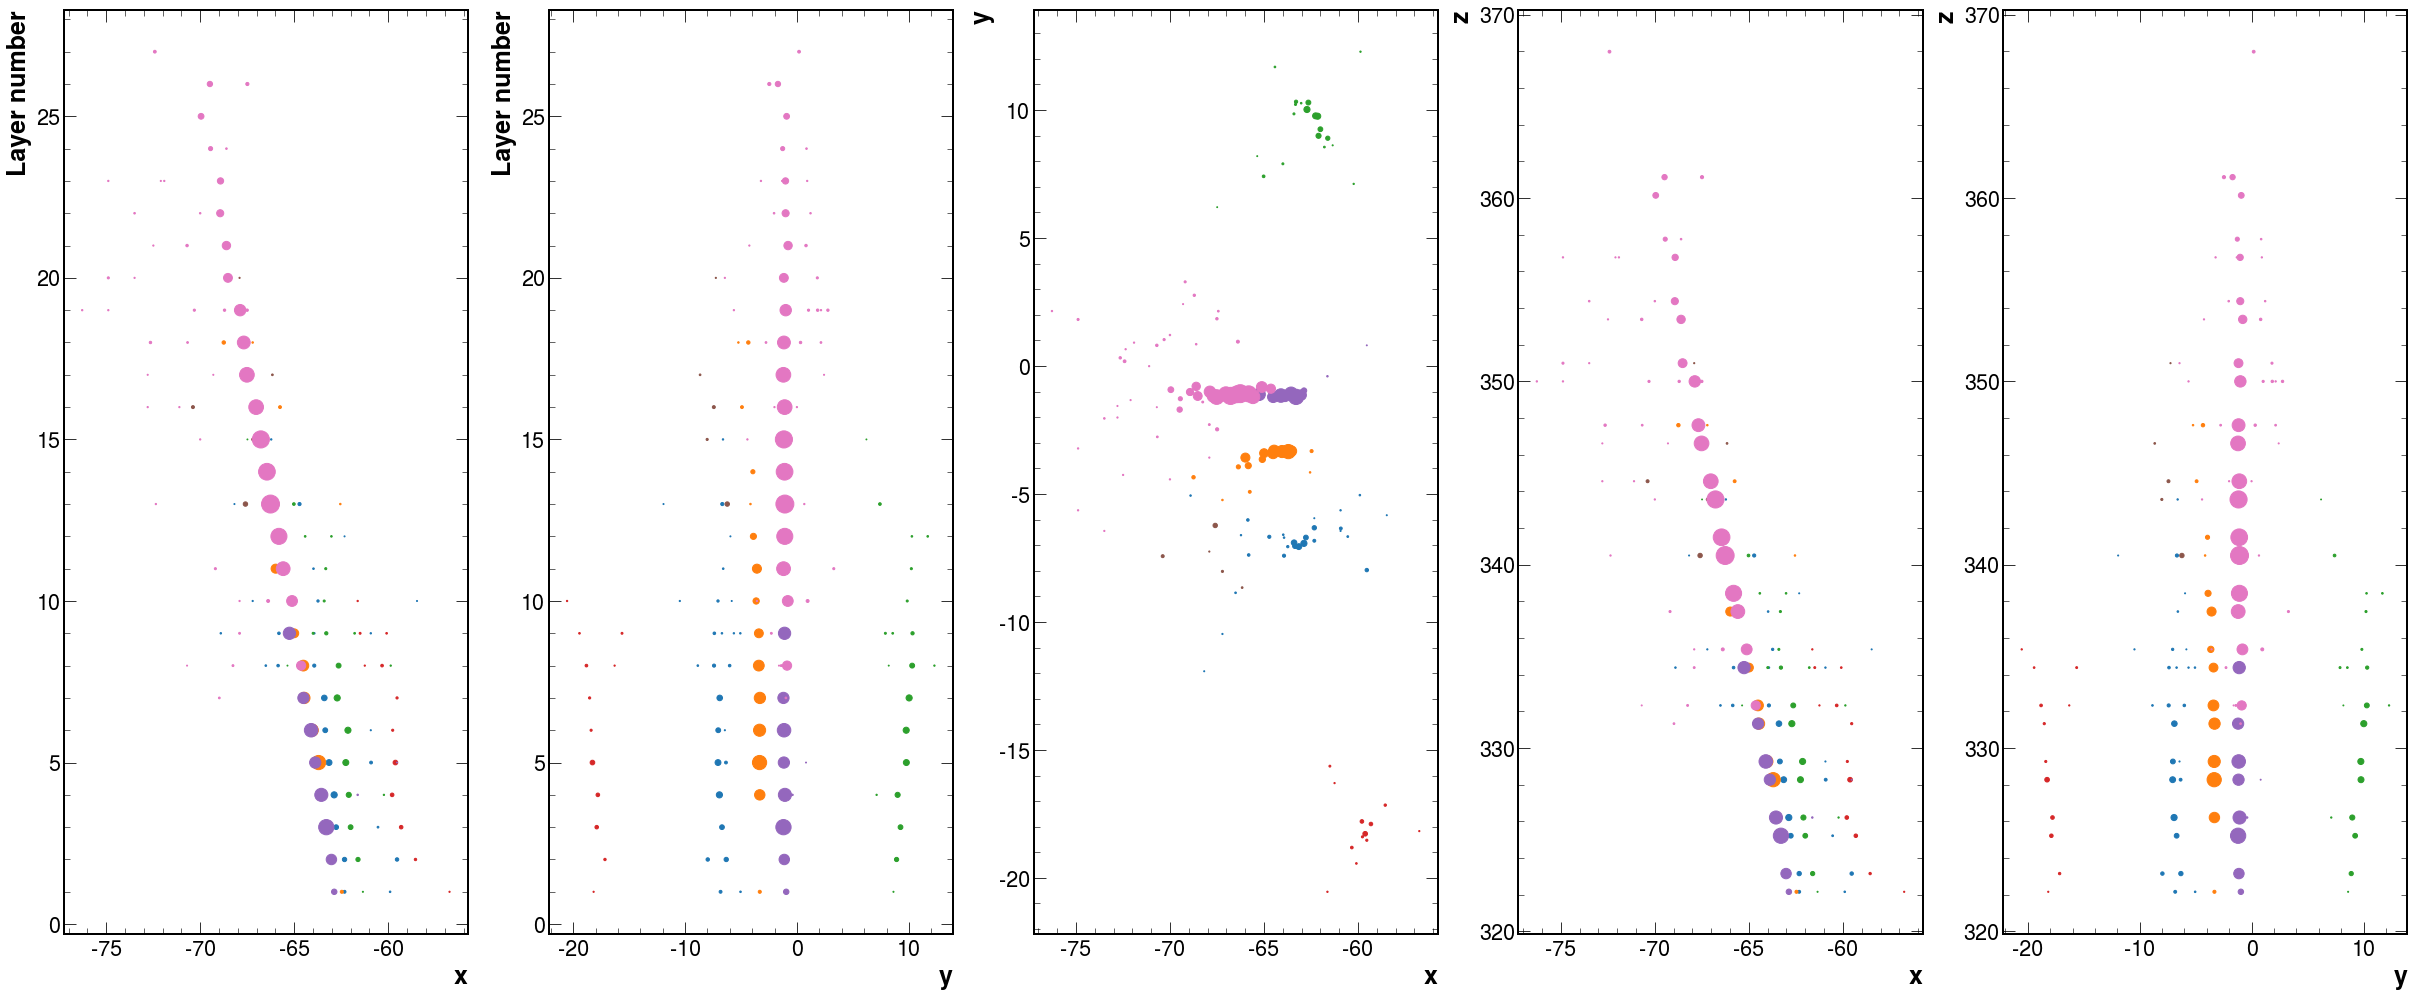

------- Tracksters information GLUE -------
color    energy     ratio_maxE     ratio_sumE     explVarRatio    discarded
blue      8.656      9.63%      4.77%          False
orange      32.97      36.67%      18.17%          False
green      8.198      9.12%      4.52%          False
red      2.681      2.98%      1.48%          False
purple      37.792      42.03%      20.83%          False
brown      1.236      1.38%      0.68%          False
pink      89.906      100.0%      49.55%          False
------- Effects of the skimming -------
E_ev/E_GEN -0.11257970173785059
E_ev/E_GEN -0.11257970173785059


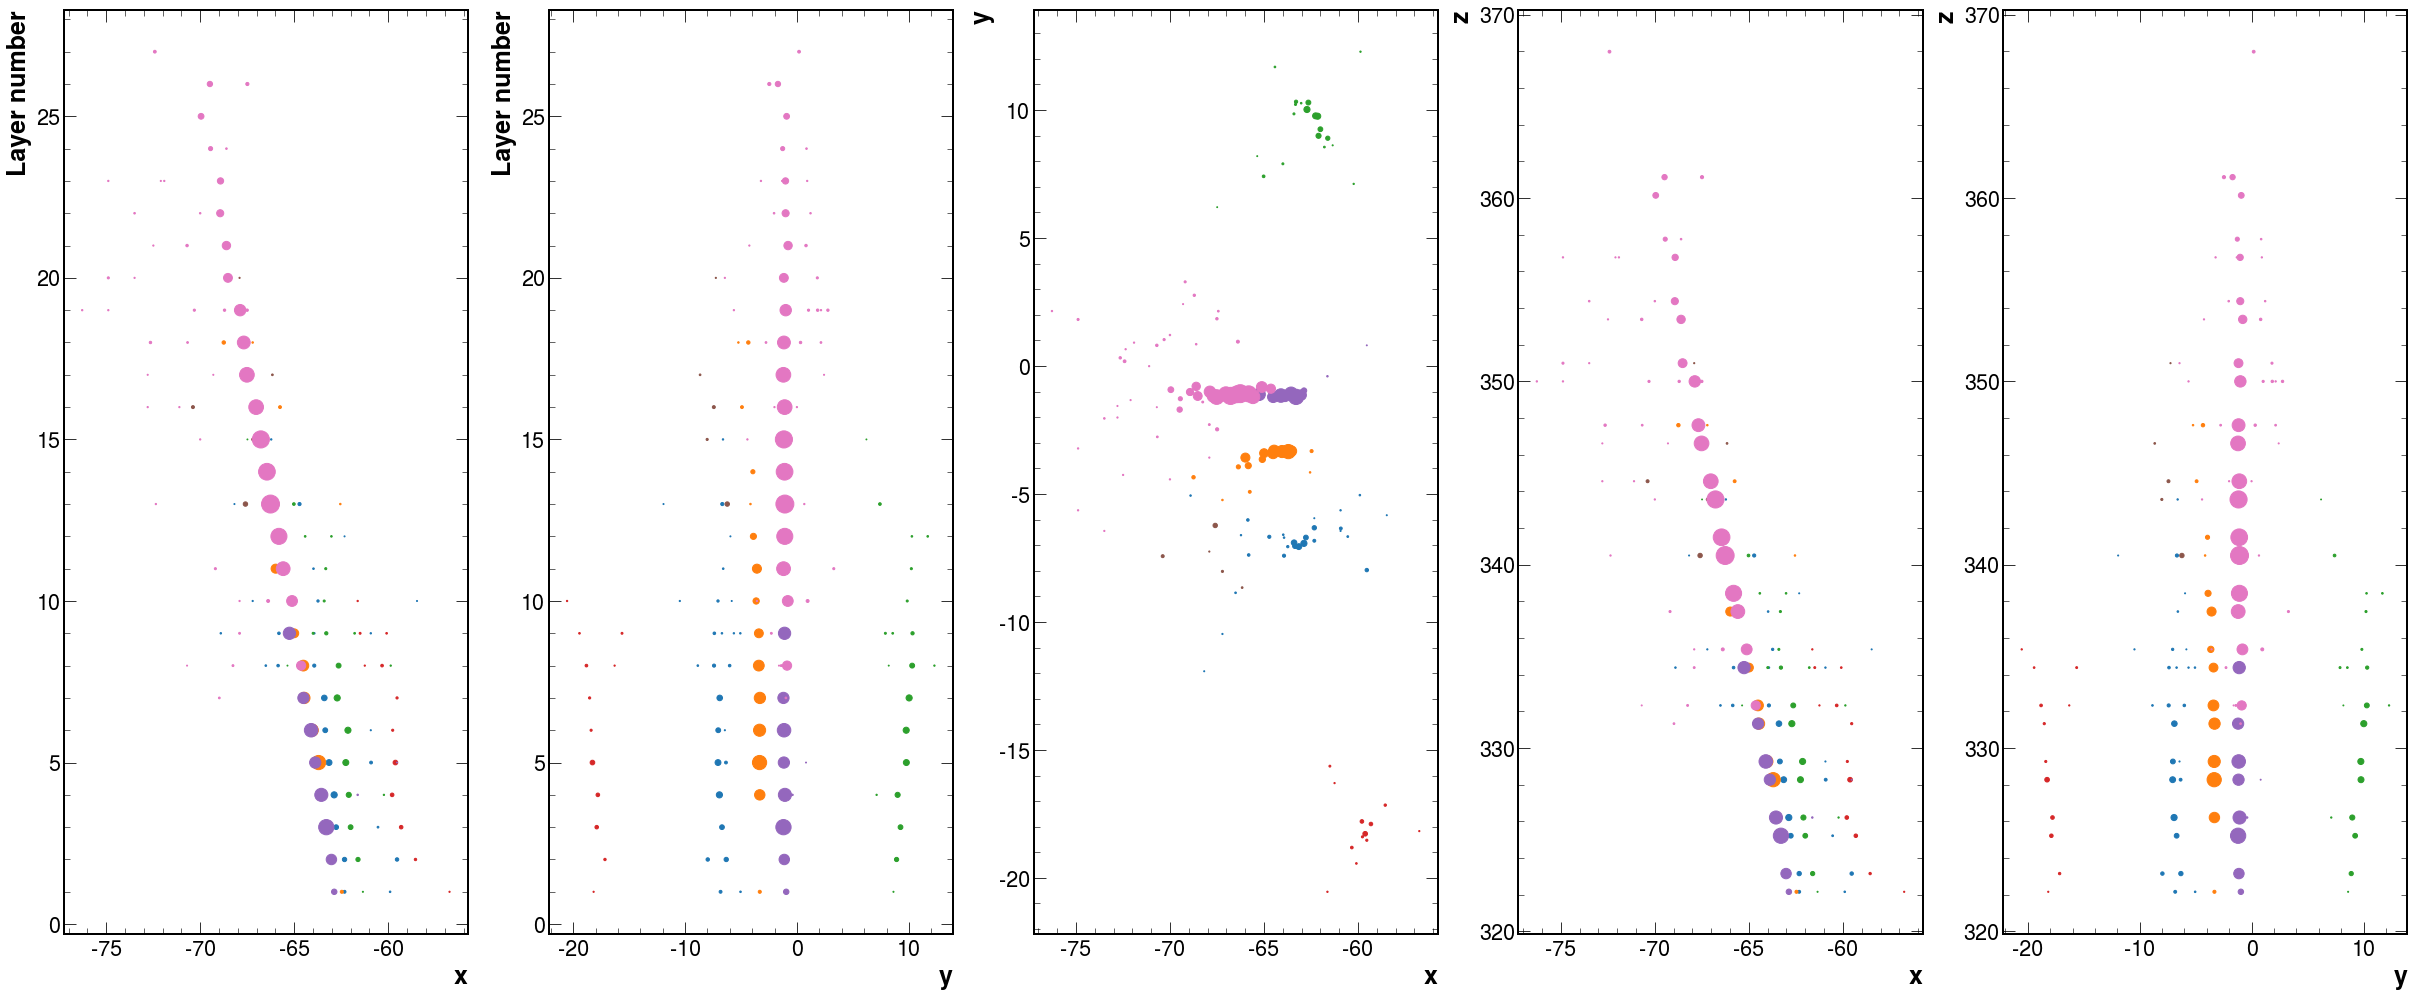

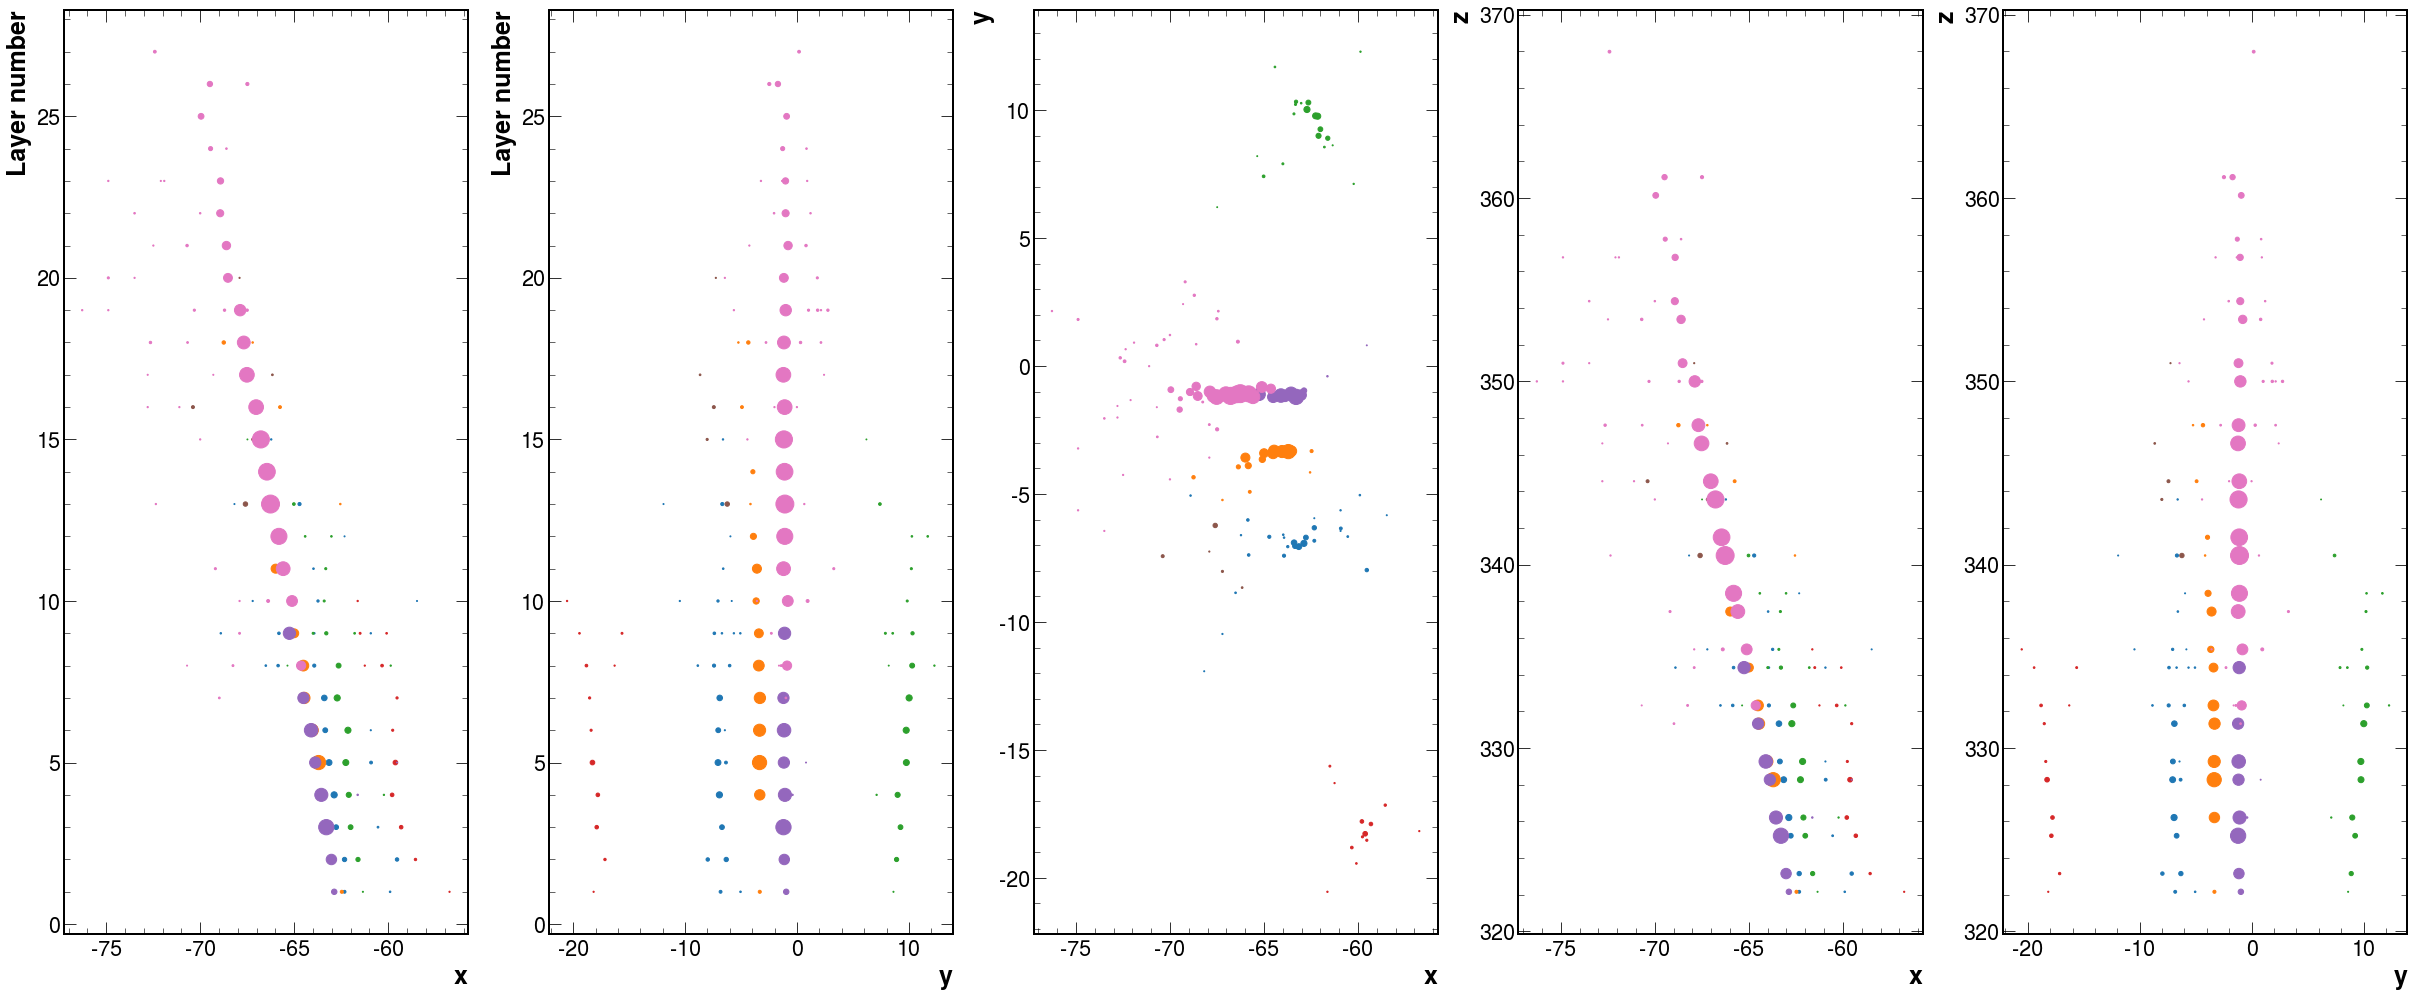

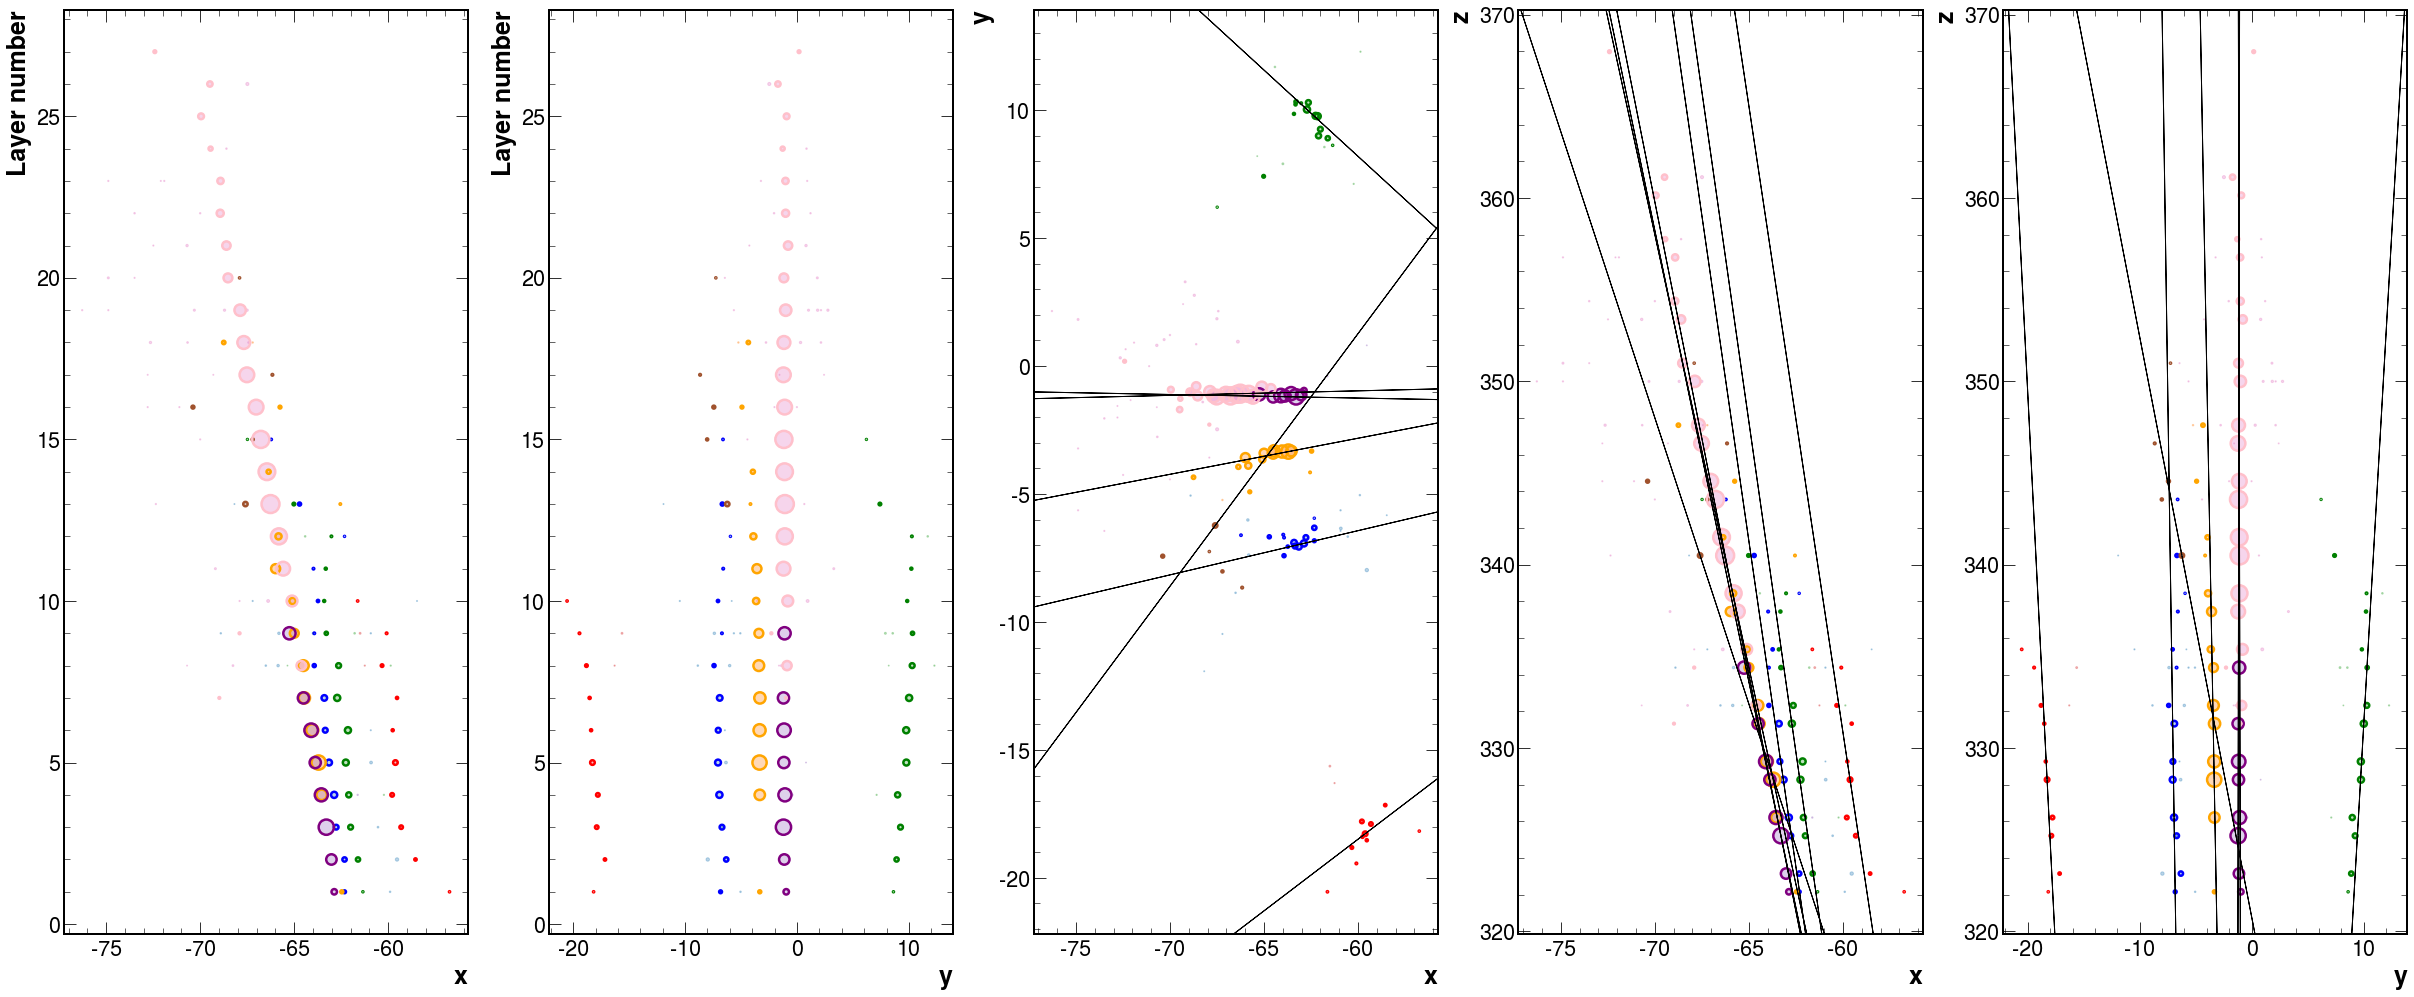

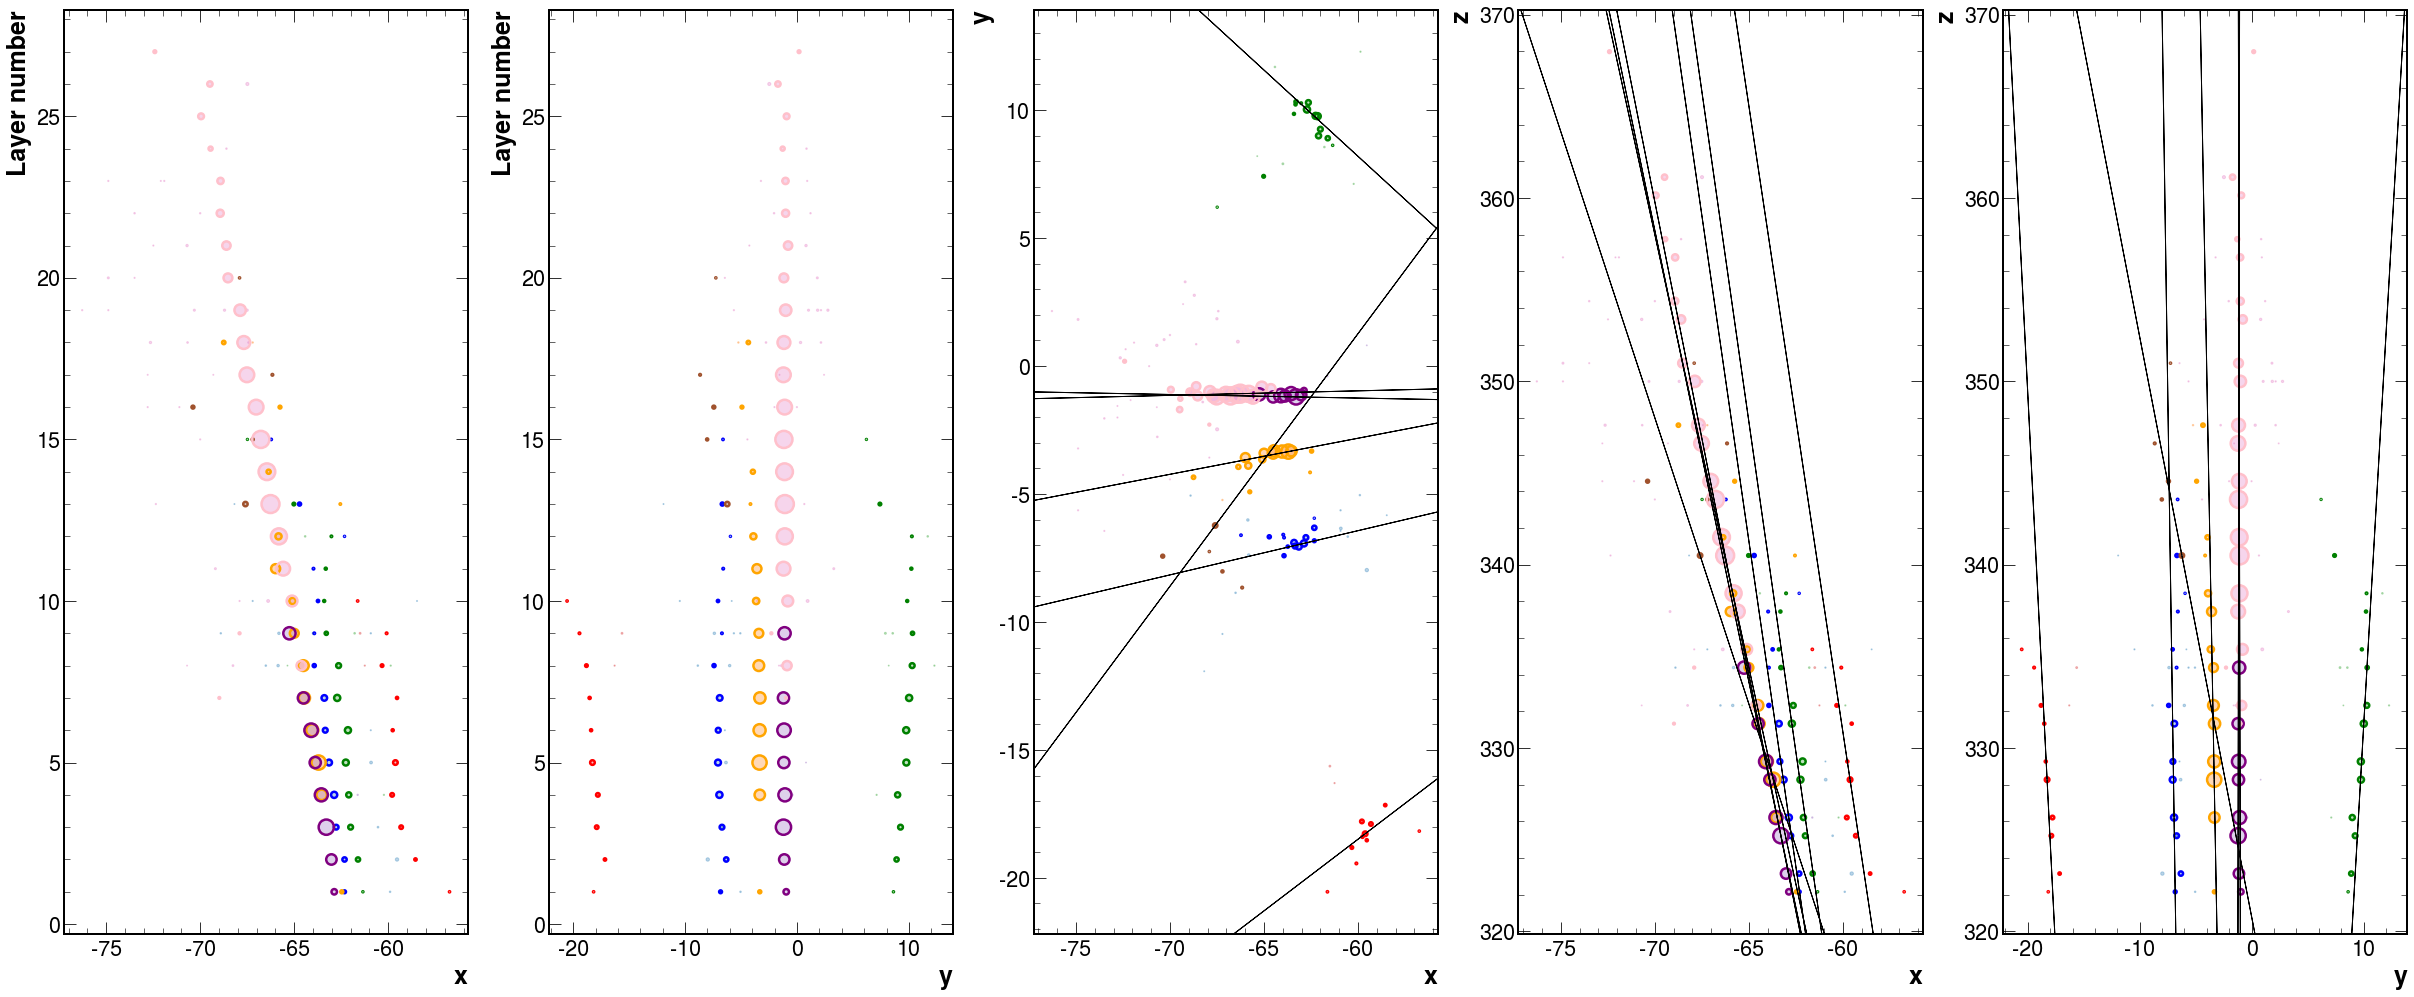

In [157]:
event   = 35
sample  = 1
eta     = 1

print(findIndex(event, sample, eta))

eventDisplay(ele_CLUE[findIndex(event, sample, eta)[0]], ele_GLUE[findIndex(event, sample, eta)[1]], removeTrk=True, cleaned = True)
# eventDisplay(ele_linking[findIndex(event, sample, eta)[0]], ele_linking[findIndex(event, sample, eta)[0]], removeTrk=False, cleaned = False)
# eventDisplay(ele_noLinking[findIndex(event, sample, eta)[1]], ele_noLinking[findIndex(event, sample, eta)[1]], removeTrk=False, cleaned = False)

In [318]:
plot3D(ele[38535])

event, sample, eta: 60 118 -1


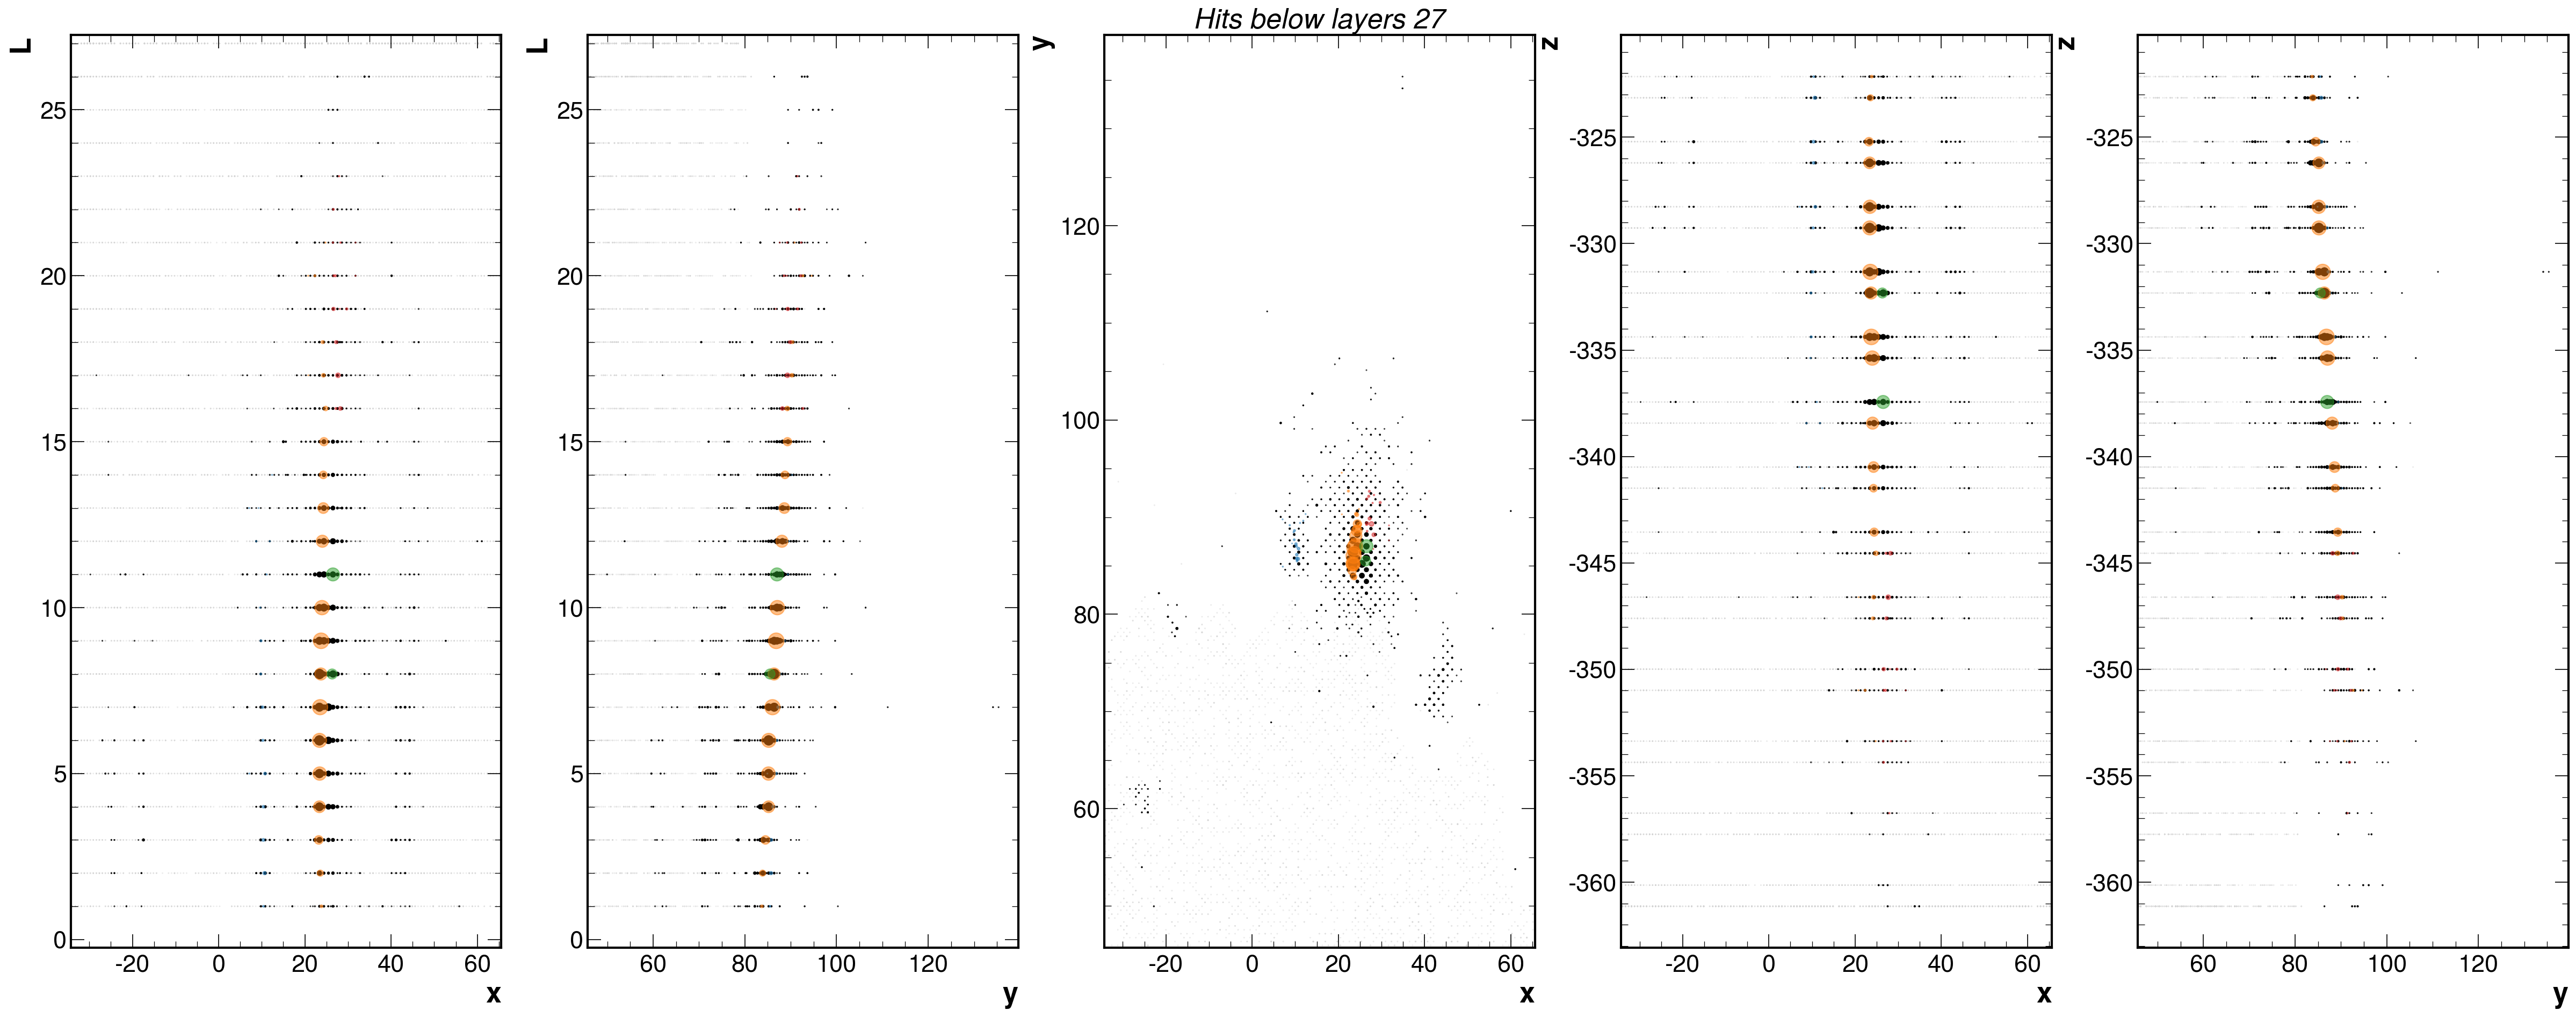

In [153]:
eventDisplayHits(ele_CLUE[findIndex(60, 118, -1)[0]])

# GLUE3D vs CLUE3D

In [96]:
def findIndex(_event, _sample, _eta):
    for idx in range(38551): 
        if ele_CLUE[idx].eventNumber == _event and ele_CLUE[idx].sampleNumber == _sample and ele_CLUE[idx].etaSign == _eta:
            idx_CLUE = idx
        if ele_GLUE[idx].eventNumber == _event and ele_GLUE[idx].sampleNumber == _sample and ele_GLUE[idx].etaSign == _eta:
            idx_GLUE = idx
    return idx_CLUE, idx_GLUE

In [93]:
nTracksters    = np.array([ evt.nTracksters for evt in ele_CLUE ])
eventNumber    = np.array([ evt.eventNumber for evt in ele_CLUE ])
sampleNumber   = np.array([ evt.sampleNumber for evt in ele_CLUE ])
etaSign        = np.array([ evt.etaSign for evt in ele_CLUE ])
gunEn          = np.array([ evt.gunEn for evt in ele_CLUE ])
gunEta         = np.array([ evt.gunEta for evt in ele_CLUE ])
gunPt          = np.array([ evt.gunPt for evt in ele_CLUE ])
gunPhi         = np.array([ evt.gunPhi for evt in ele_CLUE ])
df = {
    'event' : eventNumber,
    'sample': sampleNumber,
    'eta'   : etaSign,
    'gunEn' : gunEn,
    'gunEta': gunEta,
    'gunPt' : gunPt,
    'gunPhi': gunPhi,
    'nTrk'  : nTracksters
}
df_CLUE     = pd.DataFrame(data=df)

nTracksters    = np.array([ evt.nTracksters for evt in ele_GLUE ])
eventNumber    = np.array([ evt.eventNumber for evt in ele_GLUE ])
sampleNumber   = np.array([ evt.sampleNumber for evt in ele_GLUE ])
etaSign        = np.array([ evt.etaSign for evt in ele_GLUE ])
gunEn          = np.array([ evt.gunEn for evt in ele_GLUE ])
gunEta         = np.array([ evt.gunEta for evt in ele_GLUE ])
gunPt          = np.array([ evt.gunPt for evt in ele_GLUE ])
gunPhi         = np.array([ evt.gunPhi for evt in ele_GLUE ])
df = {
    'event' : eventNumber,
    'sample': sampleNumber,
    'eta'   : etaSign,
    'gunEn' : gunEn,
    'gunEta': gunEta,
    'gunPt' : gunPt,
    'gunPhi': gunPhi,
    'nTrk'  : nTracksters
}
df_GLUE   = pd.DataFrame(data=df)

df_merge       = pd.merge(df_CLUE, df_GLUE,  how='inner', left_on=['event','sample', 'eta', 'gunEn', 'gunEta', 'gunPt', 'gunPhi'], right_on = ['event','sample', 'eta', 'gunEn', 'gunEta', 'gunPt', 'gunPhi'])

Trk_Linking    = np.array(df_merge['nTrk_x'])
Trk_noLinking  = np.array(df_merge['nTrk_y'])

print('Total number of events:', len(Trk_Linking))
print('N_trk_Link != N_trk_noLink:', len(Trk_Linking[Trk_Linking!=Trk_noLinking]))
print('Fraction:', str(round(len(Trk_Linking[Trk_Linking!=Trk_noLinking]) / len(Trk_Linking) * 100, 2))+' %' )

Total number of events: 38551
N_trk_Link != N_trk_noLink: 6023
Fraction: 15.62 %


In [365]:
df_merge[df_merge.nTrk_x!=df_merge.nTrk_y]

,event,sample,eta,gunEn,gunEta,gunPt,gunPhi,nTrk_x,nTrk_y
6,4,101,1,499.560669,2.540518,78.269983,1.531490,8,7
25,14,101,-1,57.670578,-2.212994,12.466045,-1.383437,3,2
37,20,101,-1,48.080112,-1.875803,14.396782,-0.046863,4,3
39,21,101,-1,562.758911,-2.428829,98.438393,1.865483,7,6
60,27,101,-1,167.119873,-1.690281,59.627435,-2.457952,3,2
...,...,...,...,...,...,...,...,...,...
38527,89,94,-1,215.907318,-1.870272,64.991791,2.229481,3,2
38528,100,86,-1,68.752632,-1.805455,22.010912,-1.462816,4,3
38535,93,94,1,247.775803,2.001127,65.787873,1.328584,4,3
38542,96,94,-1,176.052933,-1.824365,55.360986,1.908084,3,2


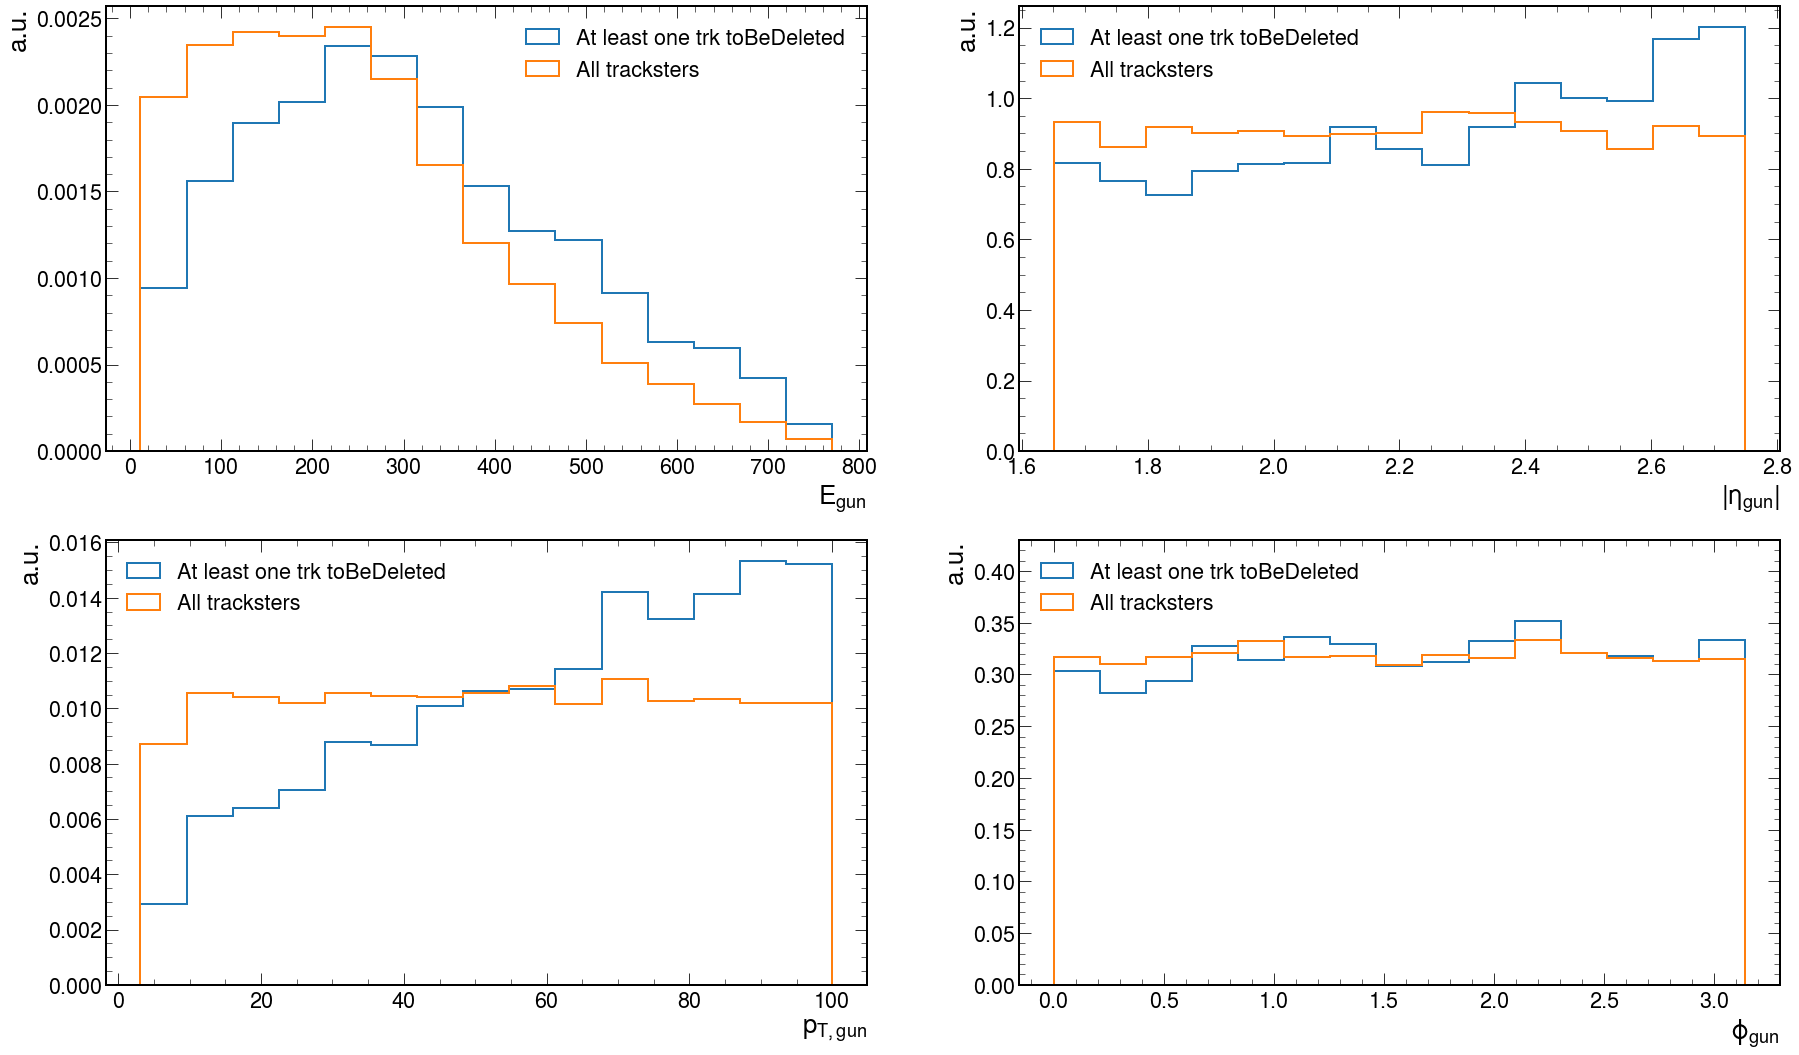

In [300]:
fig, axs = plt.subplots(2, 2, figsize=(30,18))

n,bins, _ = axs[0,0].hist(df_merge[df_merge.nTrk_x!=df_merge.nTrk_y]['gunEn'], bins=15, histtype='step', lw=2, label = 'At least one trk toBeDeleted', density=True)
axs[0,0].hist(df_Linking['gunEn'], bins=bins, histtype='step', lw=2, label = 'All tracksters', density=True)
axs[0,0].set_xlabel(r'$E_{gun}$')
axs[0,0].set_ylabel('a.u.')
axs[0,0].legend()

n, bins, _ = axs[0,1].hist(abs(df_merge[df_merge.nTrk_x!=df_merge.nTrk_y]['gunEta']), bins=15, histtype='step', lw=2, label = 'At least one trk toBeDeleted', density=True)
axs[0,1].hist(abs(df_Linking['gunEta']), bins=bins, histtype='step', lw=2, label = 'All tracksters', density=True)
axs[0,1].set_xlabel(r'|$\eta_{gun}$|')
axs[0,1].set_ylabel('a.u.')
axs[0,1].legend(loc='upper left')

n, bins, _ = axs[1,0].hist(abs(df_merge[df_merge.nTrk_x!=df_merge.nTrk_y]['gunPt']), bins=15, histtype='step', lw=2, label = 'At least one trk toBeDeleted', density=True)
axs[1,0].hist(abs(df_Linking['gunPt']), bins=bins, histtype='step', lw=2, label = 'All tracksters', density=True)
axs[1,0].set_xlabel(r'$p_{T,gun}$')
axs[1,0].set_ylabel('a.u.')
axs[1,0].legend(loc='upper left')

n, bins, _ = axs[1,1].hist(abs(df_merge[df_merge.nTrk_x!=df_merge.nTrk_y]['gunPhi']), bins=15, histtype='step', lw=2, label = 'At least one trk toBeDeleted', density=True)
axs[1,1].hist(abs(df_Linking['gunPhi']), bins=bins, histtype='step', lw=2, label = 'All tracksters', density=True)
axs[1,1].set_xlabel(r'$\phi_{gun}$')
axs[1,1].set_ylabel('a.u.')
axs[1,1].set_ylim([0,0.43])
axs[1,1].legend(loc='upper left')


plt.show()

Number of tracksters per event (%): [21.22178988326848, 24.32684824902724, 19.372243839169908, 13.841763942931259, 9.019455252918288, 5.543450064850843, 3.2607003891050583, 1.77431906614786, 0.8897535667963684, 0.4357976653696498, 0.17380025940337224, 0.0959792477302205, 0.03372243839169909, 0.010376134889753566]
Number of tracksters per event (%): [23.631647211413746, 25.21660181582361, 19.418936446173802, 13.276264591439688, 8.337224383916991, 4.95201037613489, 2.6977950713359276, 1.3748378728923476, 0.6433203631647211, 0.2879377431906615, 0.09857328145265888, 0.057068741893644616, 0.007782101167315175, 0.0]


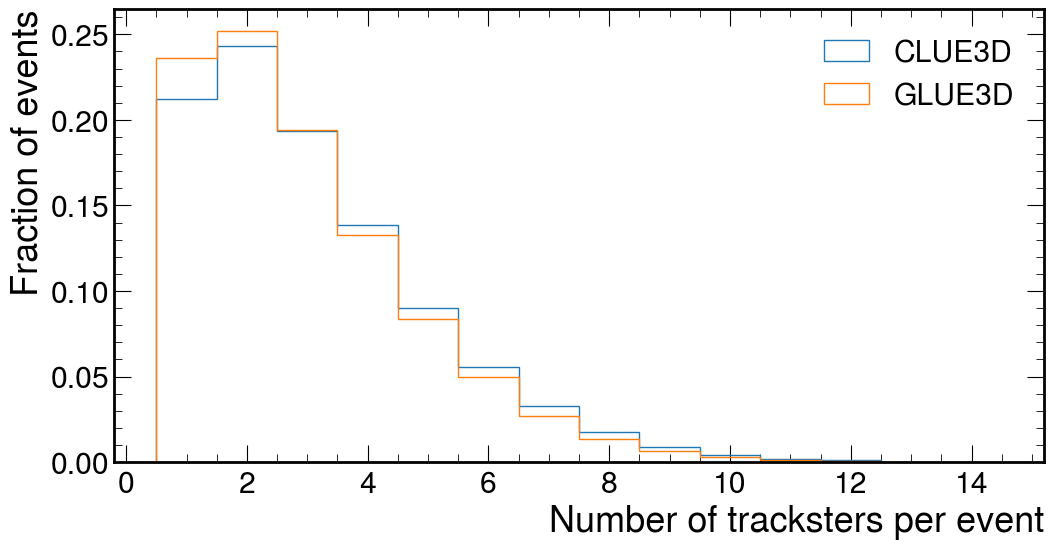

In [206]:
plt.figure(figsize=(12, 6), dpi=100)

nTracksters = np.array([ evt.nTracksters for evt in ele_linking ])
n, bins, _ = plt.hist(nTracksters, density = True, bins=14, range=[0.5,14.5], histtype='step', label='CLUE3D')

print('Number of tracksters per event (%):', [i*100 for i in n])

#### ------ After skimming tracksters according to wpca_explVarRatio ------ ####

nTracksters_noLinking = np.array([ evt.nTracksters for evt in ele_noLinking ])
n, bins, _ = plt.hist(nTracksters_noLinking, density = True, bins=14, range=[0.5,14.5], histtype='step', label='GLUE3D')

print('Number of tracksters per event (%):', [i*100 for i in n])


# plt.yscale('log')
plt.ylabel('Fraction of events')
plt.xlabel('Number of tracksters per event')
plt.legend()
plt.show()